### [Choosing Indexes for Similarity Search](https://www.youtube.com/watch?v=B7wmo_NImgM)
#### [FAISS indexes](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from langchain.text_splitter import CharacterTextSplitter, SpacyTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader

state_of_the_union_path = '/Users/shivramamurthi/models/state_of_the_union.txt' 
raw_documents = TextLoader(state_of_the_union_path).load()
# text_splitter = CharacterTextSplitter(chunk_size=1024, chunk_overlap=0)
# text_splitter = SpacyTextSplitter(chunk_size=512, chunk_overlap=0)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=128, chunk_overlap=32, keep_separator=False)

# splitter.split_text
with open(state_of_the_union_path) as f:
    state_of_the_union_raw_txt = f.read()
state_of_the_union_txts = text_splitter.split_text(state_of_the_union_raw_txt)
state_of_the_union_txts

['Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the',
 'and the Cabinet. Justices of the Supreme Court. My fellow Americans.',
 'Last year COVID-19 kept us apart. This year we are finally together again.',
 'Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans.',
 'With a duty to one another to the American people to the Constitution.',
 'And with an unwavering resolve that freedom will always triumph over tyranny.',
 'Six days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his',
 'he could make it bend to his menacing ways. But he badly miscalculated.',
 'He thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined.',
 'He met the Ukrainian people.',
 'From President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determin

In [3]:
from langchain_community.embeddings import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name='all-mpnet-base-v2')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
wb = embeddings.embed_documents(state_of_the_union_txts)
print(wb[0])
docs = np.array(wb)
docs.shape

[0.02903173491358757, 0.04225386679172516, -0.011469412595033646, 0.05603702738881111, 0.0005548094632104039, 0.03614511713385582, -0.026928696781396866, 0.0194407869130373, -0.02477710321545601, -0.01740158349275589, 0.028604134917259216, -0.024095790460705757, 0.05767561495304108, -0.08821713179349899, 0.017734039574861526, -0.11374872922897339, 0.03972000256180763, 0.02998572587966919, 0.019094305112957954, -0.029063081368803978, -0.04141855239868164, 0.005377991124987602, -0.006000692956149578, -0.002463475801050663, -0.004375917837023735, -0.024192582815885544, 0.01832258515059948, 0.03980809822678566, -0.023939022794365883, 0.02313213236629963, 0.02961539849638939, 0.010070184245705605, 0.033288370817899704, -0.0949089452624321, 1.7349170775560196e-06, 0.009497522376477718, 0.033823031932115555, -0.0036529984790831804, -0.04752003774046898, -0.07106965035200119, -0.01105085201561451, -0.008625498972833157, -0.025923781096935272, 0.012520669028162956, 0.03638722747564316, 0.001344

(432, 768)

In [5]:
# eq = embeddings.embed_query('we’ve mobilized American ground forces, air squadrons, and ship deployments to protect NATO countries')
eq = embeddings.embed_query('What did the president say about Military Intelligence?')
xq = np.array(eq)
xq = xq.reshape(1, xq.shape[0])
xq.shape

(1, 768)

In [6]:
# short to long
explore_queries = [
    'Ukraine',
    'Military Intelligence',
    'hate crimes to reforming military justice.',
    'Poland, Romania, Latvia, Lithuania, and Estonia',
    'What did the president say about Military Intelligence?',
    'We are joining with our European allies to find and seize your yachts your luxury apartments your private jets'
]
eqs = [
    (eq, np.array(embeddings.embed_query(eq)))
    for eq in explore_queries ]
eqs = [ (eq[0], eq[1].reshape(1, len(eq[1]))) for eq in eqs ] # [ (q query, (1, 768) dim embedding vector) ]

In [7]:
import faiss

### Flat

In [8]:
d = len(docs[1])  # dimensionality of embedding vectors
k = 10  # number of nearest neighbors to return

In [9]:
d

768

In [10]:
index = faiss.IndexFlatL2(d)
index.add(docs)
index.ntotal

432

##### Store baseline doc results per query

In [11]:
from collections import defaultdict

In [12]:
baseline_results = defaultdict(list)
baseline_mean_similarity = defaultdict(float)

In [13]:
%%time
for eq in eqs:
    q = eq[0]
    D, I = index.search(eq[1], k)
    b = baseline_results[q] = I[0]
    cos = cosine_similarity(docs[I[0]], eq[1])
    mcos = np.mean(cos)
    baseline_mean_similarity[q] = mcos
    print(f"baseline for '{q}' is '{b}' with mean cosine sim: {mcos}")

baseline for 'Ukraine' is '[46 78  9 10 61 49 14 82 15 54]' with mean cosine sim: 0.47202289728482993
baseline for 'Military Intelligence' is '[360  54 411  12 366  53  38 153  47 312]' with mean cosine sim: 0.39929429696517804
baseline for 'hate crimes to reforming military justice.' is '[360 359 318 306  11  12 413 340 408 402]' with mean cosine sim: 0.5029128510529312
baseline for 'Poland, Romania, Latvia, Lithuania, and Estonia' is '[54 30 31 46 51 56 53 13 10  9]' with mean cosine sim: 0.376548946757732
baseline for 'What did the president say about Military Intelligence?' is '[ 55  22 360 133  63  29  54  27  39  13]' with mean cosine sim: 0.38051133738686455
baseline for 'We are joining with our European allies to find and seize your yachts your luxury apartments your private jets' is '[ 39  40  41  33  55  25  51  53 134  27]' with mean cosine sim: 0.5709196612883368
CPU times: user 4.93 ms, sys: 2.17 ms, total: 7.1 ms
Wall time: 5.28 ms


### LSH
#### [nbits is number of hyperplanes](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing-random-projection/)

In [14]:
# d is number of vector dimensions
d = d
# nbits = number of hyperplanes
nbits = d*4
print(d, nbits)

768 3072


In [15]:
# create a set of nbits hyperplanes, with d dimensions
plane_norms = np.random.rand(nbits, d) - .5
plane_norms.shape

(3072, 768)

##### explore nbits (# of hyperplanes) and average cosine similarity of k vectors returned in search

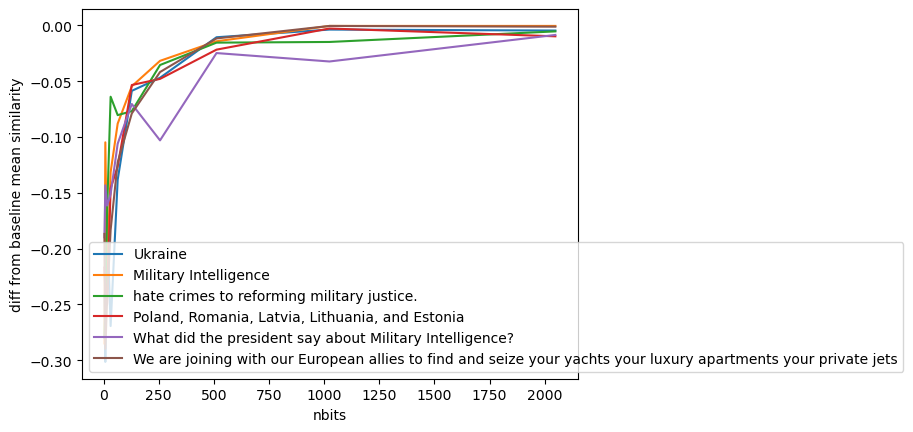

In [16]:
plt.ylabel("diff from baseline mean similarity")
plt.xlabel("nbits")

# try all queries
for eq in eqs:
    eqq, eqe = eq[0], eq[1] # eqq = 'Ukraine', eqe = 768 dim vector
    plt_x, plt_y = [], []
    
    # proceed in powers of 2
    for nbits in [2**i for i in range(2, 12)]:
        index = faiss.IndexLSH(d, nbits)
        index.add(docs)
        D, I = index.search(eqe, k=k)
        cos = cosine_similarity(docs[I[0]], eqe)
        mcos = np.mean(cos)
        diff = mcos - baseline_mean_similarity[eqq]
        plt_x.append(nbits)
        plt_y.append(diff)
        # print(f"progress: {nbits} for '{eqq}' has mean sim: {mcos}, diff: {diff}")

    plt.plot(plt_x, plt_y, label=eqq)
    plt.legend()

plt.show()

### HNSW

#### [Terminology](https://learn.microsoft.com/en-us/javascript/api/@azure/search-documents/hnswparameters?view=azure-node-latest)

- `M`
  - The number of bi-directional links created for every new element during construction.
  - Increasing this parameter value may improve recall and reduce retrieval times for datasets with high intrinsic dimensionality at the expense of increased memory consumption and longer indexing time.
- `ef_construction`
  - The size of the dynamic (candidate) list containing the nearest neighbors, which is used during index time.
  - Increasing this parameter may improve index quality, at the expense of increased indexing time.
  - At a certain point, increasing this parameter leads to diminishing returns.
- `ef_search`
  - The size of the dynamic (candidate) list containing the nearest neighbors, which is used during search time.
  - Increasing this parameter may improve search results, at the expense of slower search.
  - sIncreasing this parameter leads to diminishing returns.

In [17]:
def dump_index_stats(index):
    # max level of any doc
    max_level = index.hnsw.max_level
    print(f"max_level of any doc: {max_level}")
    
    # how many docs per level?
    levels = index.hnsw.levels
    level_of_each_doc = faiss.vector_to_array(levels)
    num_docs = len(level_of_each_doc)
    print(f"level of each doc: {level_of_each_doc} (total: {num_docs} docs)")
    
    # bins for each level: 0, 1, 2 etc.
    binned_doc_counts = np.bincount(level_of_each_doc)
    for l, bc in enumerate(binned_doc_counts[1:]):
        print(f"There are {bc} docs at level {l}")

In [18]:
M = 2
ef_search = 32
ef_construction = 64

index = faiss.IndexHNSWFlat(d, M)
index.hnsw.efConstruction = ef_construction
index.hnsw.efSearch = ef_search
index.add(docs)
dump_index_stats(index)

max_level of any doc: 7
level of each doc: [4 4 1 1 1 1 1 3 2 2 2 5 5 1 2 4 2 1 2 1 2 4 5 1 1 1 1 1 1 3 2 2 3 4 3 2 5
 3 2 1 2 3 2 4 1 1 1 2 1 1 2 3 8 1 2 2 3 2 1 1 1 3 3 2 4 3 1 4 1 3 2 4 2 6
 1 2 4 3 2 1 3 1 2 1 3 2 1 1 1 1 1 2 1 3 1 2 2 2 1 4 2 1 1 3 3 1 4 1 2 1 1
 1 1 2 1 1 3 1 4 1 1 1 1 1 2 3 1 5 1 1 2 2 3 6 2 2 6 5 2 4 4 1 1 1 1 3 2 1
 2 1 1 4 1 3 3 2 1 1 4 3 5 2 2 1 1 1 2 2 1 1 1 1 1 1 1 3 2 1 1 1 3 1 3 2 3
 1 5 1 1 1 4 1 1 1 3 1 4 3 1 1 1 4 1 1 2 1 1 1 1 3 2 1 2 1 3 1 2 1 2 1 2 3
 1 1 4 2 1 2 1 1 5 5 2 1 2 4 2 1 1 8 4 3 2 5 1 1 2 1 2 1 5 1 1 3 1 2 1 1 1
 2 1 2 1 4 2 2 2 2 2 1 1 1 1 2 4 1 3 1 1 1 1 1 2 4 1 1 1 4 1 1 3 3 1 1 2 1
 1 3 1 2 4 4 2 4 1 1 1 1 1 1 4 1 3 3 5 4 1 2 2 1 1 1 1 3 1 3 1 2 2 3 2 6 3
 1 3 2 1 2 3 1 4 3 1 4 7 3 3 1 2 5 1 1 4 2 3 1 5 3 1 2 1 1 1 2 8 2 1 1 1 2
 3 1 1 3 2 1 1 1 1 1 3 1 3 4 1 7 1 2 3 4 1 1 1 1 1 2 1 1 2 1 3 3 1 3 1 1 3
 1 1 1 1 1 2 2 1 1 2 1 1 1 3 1 1 4 2 2 2 1 1 1 2 4] (total: 432 docs)
There are 208 docs at level 0
There are 98 docs at level 1
The

##### Explore varying `ef_construction`

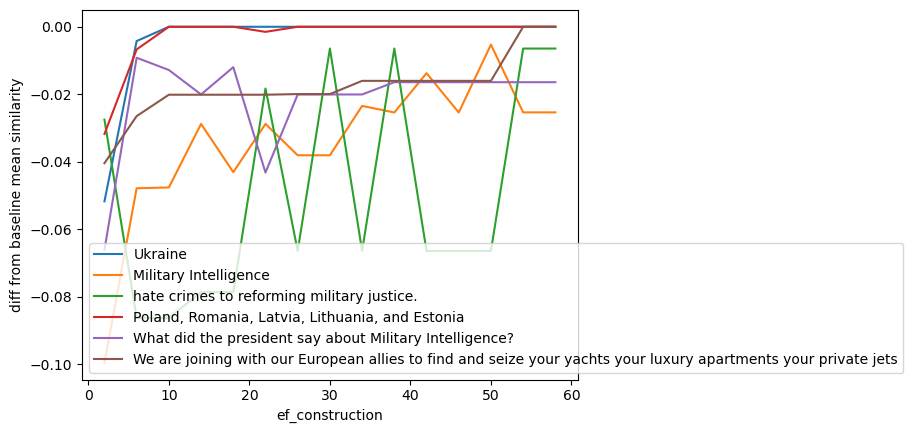

CPU times: user 1.2 s, sys: 86.4 ms, total: 1.28 s
Wall time: 787 ms


In [19]:
%%time

plt.ylabel("diff from baseline mean similarity")
plt.xlabel("ef_construction")

M = 2
ef_search = 32
ef_construction = 64

# try all queries
for eq in eqs:
    eqq, eqe = eq[0], eq[1] # eqq = 'Ukraine', eqe = 768 dim vector
    plt_x, plt_y = [], []
    
    # proceed in powers of 2
    for ef_construction in range(2, 60, 4):
        index = faiss.IndexHNSWFlat(d, M)
        index.hnsw.efConstruction = ef_construction
        index.add(docs)
        # dump_index_stats(index)
        index.hnsw.efSearch = ef_search
        D, I = index.search(eqe, k=k)
        cos = cosine_similarity(docs[I[0]], eqe)
        mcos = np.mean(cos)
        diff = mcos - baseline_mean_similarity[eqq]
        plt_x.append(ef_construction)
        plt_y.append(diff)

    plt.plot(plt_x, plt_y, label=eqq)
    plt.legend()

plt.show()

##### Explore varying `M`

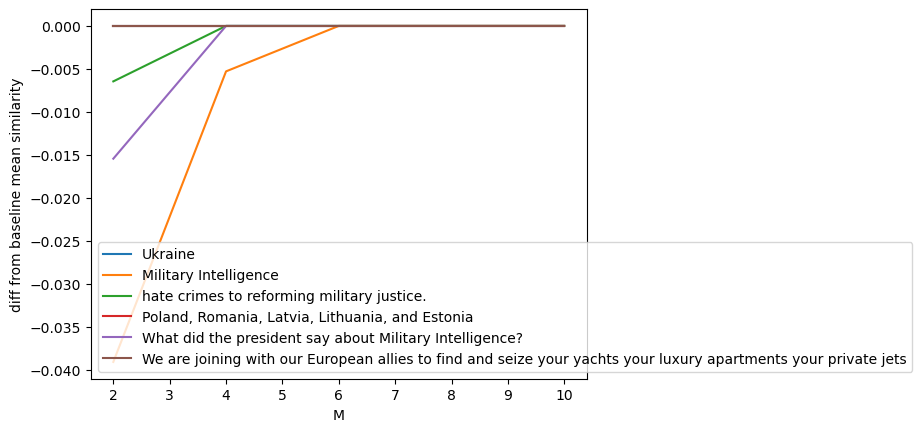

CPU times: user 906 ms, sys: 38 ms, total: 944 ms
Wall time: 313 ms


In [20]:
%%time

plt.ylabel("diff from baseline mean similarity")
plt.xlabel("M")

M = 2
ef_search = 32
ef_construction = 64

# try all queries
for eq in eqs:
    eqq, eqe = eq[0], eq[1] # eqq = 'Ukraine', eqe = 768 dim vector
    plt_x, plt_y = [], []
    
    for M in [2, 4, 6, 8, 10]:
        index = faiss.IndexHNSWFlat(d, M)
        index.hnsw.efConstruction = ef_construction
        index.add(docs)
        # dump_index_stats(index)
        index.hnsw.efSearch = ef_search
        D, I = index.search(eqe, k=k)
        cos = cosine_similarity(docs[I[0]], eqe)
        mcos = np.mean(cos)
        diff = mcos - baseline_mean_similarity[eqq]
        plt_x.append(M)
        plt_y.append(diff)

    plt.plot(plt_x, plt_y, label=eqq)
    plt.legend()

plt.show()

##### Explore varying `ef_search`

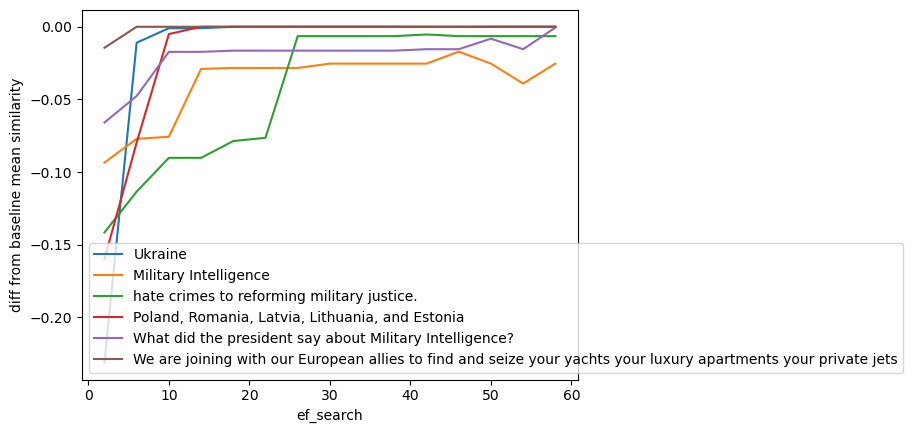

CPU times: user 1.73 s, sys: 103 ms, total: 1.83 s
Wall time: 1.06 s


In [21]:
%%time

plt.ylabel("diff from baseline mean similarity")
plt.xlabel("ef_search")

M = 2  # number of connections each vertex will have
ef_search = 32  # depth of layers explored during search
ef_construction = 64  # depth of layers explored during index construction

# try all queries
for eq in eqs:
    eqq, eqe = eq[0], eq[1] # eqq = 'Ukraine', eqe = 768 dim vector
    plt_x, plt_y = [], []
    
    for ef_search in range(2, 60, 4):
        index = faiss.IndexHNSWFlat(d, M)
        index.hnsw.efConstruction = ef_construction
        index.hnsw.efSearch = ef_search
        index.add(docs)
        # dump_index_stats(index)
        D, I = index.search(eqe, k=k)
        cos = cosine_similarity(docs[I[0]], eqe)
        mcos = np.mean(cos)
        diff = mcos - baseline_mean_similarity[eqq]
        plt_x.append(ef_search)
        plt_y.append(diff)

    plt.plot(plt_x, plt_y, label=eqq)
    plt.legend()

plt.show()

### IVF

In [22]:
nlist = 8  # number of cells/clusters to partition data into

quantizer = faiss.IndexFlatIP(d)  # how the vectors will be stored/compared
index = faiss.IndexIVFFlat(quantizer, d, nlist)
index.train(docs)  # we must train the index to cluster into cells
index.add(docs)